# 라이브러리 불러오기

In [1]:
import os
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 추가
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
from sklearn.ensemble import IsolationForest

import folium

from scipy.spatial import cKDTree

# 클러스터링 위해 추가
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans, DBSCAN
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, r2_score
from sklearn.neighbors import NearestNeighbors

# 랜덤 시드 설정

In [2]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# 데이터 불러오기

In [3]:
path = "../../../data/"  # 알잘딱 수정
train_data = pd.read_csv(path+'train.csv')
test_data = pd.read_csv(path+'test.csv')
sample_submission = pd.read_csv(path+'sample_submission.csv')

#추가
interestRate = pd.read_csv(path+'interestRate.csv')
parkInfo = pd.read_csv(path+'parkInfo.csv')
schoolInfo = pd.read_csv(path+'schoolinfo.csv')
subwayInfo = pd.read_csv(path+'subwayInfo.csv')


## 중복 값 확인 및 처리

In [4]:
duplicates = train_data[train_data.drop(columns=['index']).duplicated(keep=False)]
duplicates

,index,area_m2,contract_year_month,contract_day,contract_type,floor,built_year,latitude,longitude,age,deposit
15,15,84.9342,201907,31,2,7,2016,36.965423,127.048779,3,18000.0
16,16,84.9342,201907,31,2,7,2016,36.965423,127.048779,3,18000.0
28,28,146.4005,201911,21,2,5,2016,36.965423,127.048779,3,37000.0
29,29,146.4005,201911,21,2,5,2016,36.965423,127.048779,3,37000.0
33,33,84.9342,201912,14,2,14,2016,36.965423,127.048779,3,19000.0
...,...,...,...,...,...,...,...,...,...,...,...
1801197,1801197,101.9088,202308,22,2,11,2010,37.528394,126.659398,13,33000.0
1801198,1801198,114.9285,202308,28,1,18,2010,37.528394,126.659398,13,30000.0
1801199,1801199,114.9285,202308,28,1,18,2010,37.528394,126.659398,13,30000.0
1801210,1801210,114.9285,202310,26,2,9,2010,37.528394,126.659398,13,39000.0


In [5]:
# 중복 제거 (첫 번째 발생 유지)
train_data = train_data.drop_duplicates(subset=train_data.columns.drop('index'), keep='first')
train_data

,index,area_m2,contract_year_month,contract_day,contract_type,floor,built_year,latitude,longitude,age,deposit
0,0,84.9981,201906,25,2,9,2019,37.054314,127.045216,0,17000.0
1,1,84.9981,202003,26,2,20,2019,37.054314,127.045216,1,23000.0
2,2,84.9981,202003,28,2,8,2019,37.054314,127.045216,1,23000.0
3,3,59.3400,201907,15,2,1,1986,36.964647,127.055847,33,5000.0
4,4,59.8100,201904,12,2,6,1995,36.972390,127.084514,24,1800.0
...,...,...,...,...,...,...,...,...,...,...,...
1801223,1801223,114.8126,202311,25,0,5,2010,37.528394,126.659398,13,39000.0
1801224,1801224,101.9088,202311,28,0,6,2010,37.528394,126.659398,13,38000.0
1801225,1801225,114.7900,202312,3,0,19,2010,37.528394,126.659398,13,37000.0
1801226,1801226,101.9088,202312,4,1,15,2010,37.528394,126.659398,13,34400.0


# 데이터 EDA 수행하기

In [6]:
# 변경 print() -> display()
display("train, test_data, sample_submission shape : ", train_data.shape, test_data.shape, sample_submission.shape)
display("train data 상단 5개 정보 확인 : ", train_data.head())
display("test data 상단 5개 정보 확인 : ", test_data.head())
# display("sample_submission 상단 5개 정보 확인 : ", sample_submission.head())
display("train data 변수 요약 정보 확인 : ", train_data.describe())
display("test data 변수 요약 정보 확인 : ", test_data.describe())

'train, test_data, sample_submission shape : '

(1717611, 11)

(150172, 10)

(150172, 2)

'train data 상단 5개 정보 확인 : '

,index,area_m2,contract_year_month,contract_day,contract_type,floor,built_year,latitude,longitude,age,deposit
0,0,84.9981,201906,25,2,9,2019,37.054314,127.045216,0,17000.0
1,1,84.9981,202003,26,2,20,2019,37.054314,127.045216,1,23000.0
2,2,84.9981,202003,28,2,8,2019,37.054314,127.045216,1,23000.0
3,3,59.3400,201907,15,2,1,1986,36.964647,127.055847,33,5000.0
4,4,59.8100,201904,12,2,6,1995,36.972390,127.084514,24,1800.0


'test data 상단 5개 정보 확인 : '

,index,area_m2,contract_year_month,contract_day,contract_type,floor,built_year,latitude,longitude,age
0,0,84.961,202404,12,1,14,2016,36.965423,127.048779,8
1,1,59.900,202404,13,0,4,1997,36.963105,127.040678,27
2,2,39.270,202404,29,0,5,1990,36.957089,127.047449,34
3,3,39.270,202405,3,0,1,1990,36.957089,127.047449,34
4,4,46.980,202406,2,0,4,1990,36.957089,127.047449,34


'train data 변수 요약 정보 확인 : '

,index,area_m2,contract_year_month,contract_day,contract_type,floor,built_year,latitude,longitude,age,deposit
count,1.717611e+06,1.717611e+06,1.717611e+06,1.717611e+06,1.717611e+06,1.717611e+06,1.717611e+06,1.717611e+06,1.717611e+06,1.717611e+06,1.717611e+06
mean,9.019507e+05,7.524180e+01,2.021336e+05,1.590339e+01,1.201827e+00,1.004954e+01,2.004139e+03,3.747743e+01,1.269666e+02,1.713041e+01,3.823133e+04
std,5.193502e+05,2.558576e+01,1.353578e+02,8.629776e+00,8.825039e-01,6.965997e+00,1.114347e+01,1.623614e-01,1.697936e-01,1.111990e+01,2.617477e+04
min,0.000000e+00,1.032150e+01,2.019040e+05,1.000000e+00,0.000000e+00,-4.000000e+00,1.961000e+03,3.691791e+01,1.264787e+02,-3.000000e+00,3.000000e+02
25%,4.534005e+05,5.975010e+01,2.020080e+05,9.000000e+00,0.000000e+00,5.000000e+00,1.995000e+03,3.738028e+01,1.268431e+02,7.000000e+00,2.100000e+04
50%,9.022850e+05,7.792000e+01,2.021110e+05,1.600000e+01,2.000000e+00,9.000000e+00,2.004000e+03,3.750246e+01,1.269977e+02,1.700000e+01,3.200000e+04
75%,1.351972e+06,8.496000e+01,2.022120e+05,2.300000e+01,2.000000e+00,1.400000e+01,2.015000e+03,3.758211e+01,1.270887e+02,2.600000e+01,4.800000e+04
max,1.801227e+06,3.173600e+02,2.023120e+05,3.100000e+01,2.000000e+00,6.800000e+01,2.024000e+03,3.818194e+01,1.276609e+02,6.200000e+01,1.100000e+06


'test data 변수 요약 정보 확인 : '

,index,area_m2,contract_year_month,contract_day,contract_type,floor,built_year,latitude,longitude,age
count,150172.00000,150172.000000,150172.000000,150172.000000,150172.000000,150172.000000,150172.000000,150172.000000,150172.000000,150172.000000
mean,75085.50000,74.509956,202403.137576,14.816650,0.426071,10.060557,2004.908292,37.474571,126.967625,19.091708
std,43351.06665,23.971424,1.645994,8.537693,0.597423,6.982813,11.460352,0.166952,0.172066,11.460352
min,0.00000,10.780000,202401.000000,1.000000,0.000000,-3.000000,1966.000000,36.957089,126.478708,0.000000
25%,37542.75000,59.760000,202402.000000,7.000000,0.000000,5.000000,1995.000000,37.372616,126.841057,8.000000
50%,75085.50000,75.793700,202403.000000,15.000000,0.000000,9.000000,2004.000000,37.500382,126.998922,20.000000
75%,112628.25000,84.958200,202405.000000,22.000000,1.000000,14.000000,2016.000000,37.588872,127.091862,29.000000
max,150171.00000,273.860000,202406.000000,31.000000,2.000000,60.000000,2024.000000,38.106033,127.660896,58.000000


In [7]:
display("train data 데이터 타입 확인 : ", train_data.dtypes)
display("test data 데이터 타입 확인 : ", test_data.dtypes)

'train data 데이터 타입 확인 : '

index                    int64
area_m2                float64
contract_year_month      int64
contract_day             int64
contract_type            int64
floor                    int64
built_year               int64
latitude               float64
longitude              float64
age                      int64
deposit                float64
dtype: object

'test data 데이터 타입 확인 : '

index                    int64
area_m2                float64
contract_year_month      int64
contract_day             int64
contract_type            int64
floor                    int64
built_year               int64
latitude               float64
longitude              float64
age                      int64
dtype: object

# 추가 EDA

#### 상관계수 히트맵

강한 양/음의 상관관계를 가지는 변수가 없어 보입니다.

독립변수 추가 후에 다시 확인해볼 수도 있습니다.

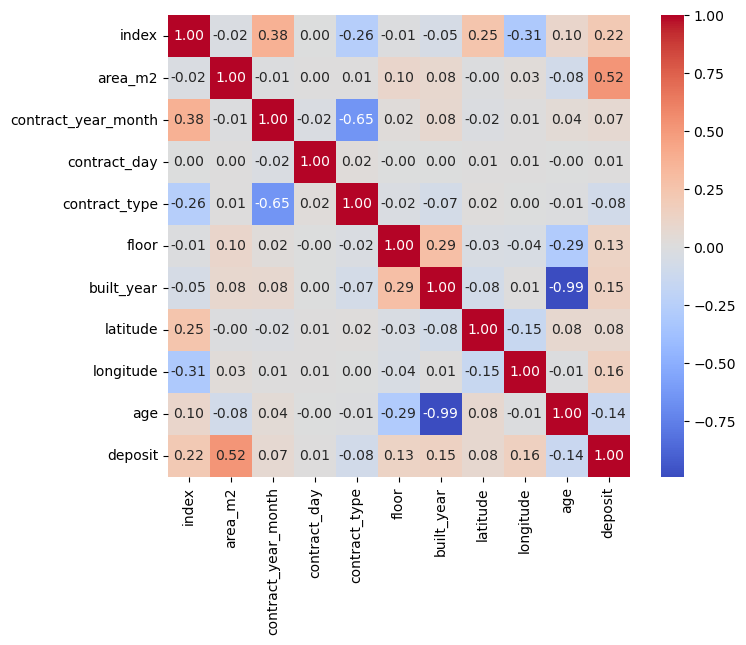

In [8]:
correlation_matrix = train_data.corr()

# 히트맵 그리기
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
# plt.title('Correlation Heatmap')
plt.show()

#### 결측치

In [9]:
# 결측치 개수 및 비율 확인
display(train_data.isnull().sum().sort_values(ascending=False))
# display(train_data.isnull().mean().sort_values(ascending=False))

index                  0
area_m2                0
contract_year_month    0
contract_day           0
contract_type          0
floor                  0
built_year             0
latitude               0
longitude              0
age                    0
deposit                0
dtype: int64

가 없습니다. ㄴ(°0°)ㄱ

#### 이상치


이상치 시각화

In [10]:
# # 박스플롯 그려보기

# def plot_boxplots(data, columns):
#     for column in columns:
#         plt.figure(figsize=(10, 6))
#         sns.boxplot(data=data[column])
#         plt.title(f'Box Plot of {column}')
#         plt.xlabel(column)
#         plt.show()

# desired_columns = ['area_m2', 'floor', 'deposit', 'age']
# plot_boxplots(train_data, desired_columns)

이상치 대체 방법들 (deposit을 예로)

In [11]:
# # 1. z-score의 값이 3(조정 가능) 이상인 데이터를 이상치로 간주

# z_scores = stats.zscore(train_data['deposit'])
# train_data['z_score'] = z_scores
# outliers_z = train_data[train_data['z_score'].abs() > 3]

# # 이상치에 해당하는 값을 중간 값 대체
# median_value = train_data['deposit'].median()
# train_data.loc[train_data['z_score'].abs() > 3, 'deposit'] = median_value

In [12]:
# # 2. Winsorization: 극단 값의 상한과 하한을 제거

# lower_limit = train_data['deposit'].quantile(0.01)
# upper_limit = train_data['deposit'].quantile(0.99)
# train_data['deposit'] = train_data['deposit'].clip(lower=lower_limit, upper=upper_limit)


In [13]:
# # 4. Isolation Forest: anomaly detection 모델 사용하기

# iso_forest = IsolationForest(contamination=0.05)  # 이상치 비율 설정
# train_data['anomaly'] = iso_forest.fit_predict(train_data[['deposit']])
# outliers_if = train_data[train_data['anomaly'] == -1]

# # 이후 outliers_if에 대해 제거하거나 대체하는 방법 사용

#### 기본 데이터 활용

변수들의 분포 확인 (42초 걸려용)

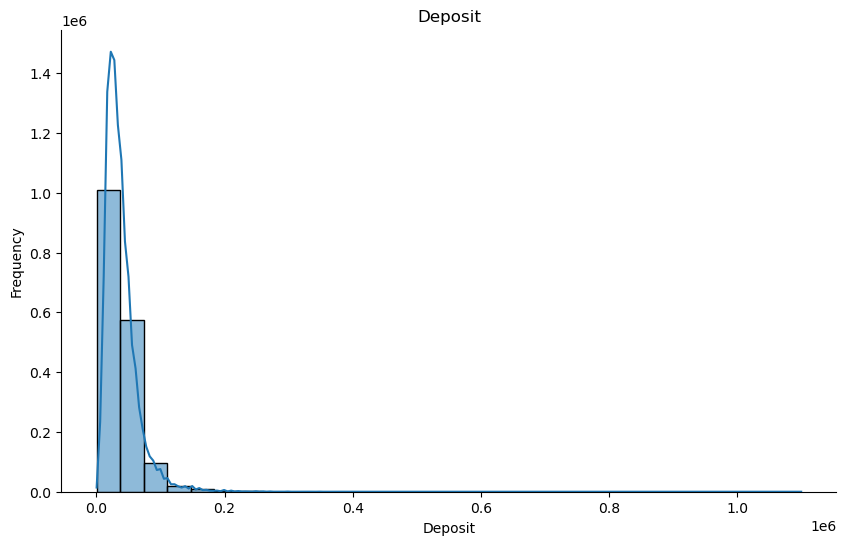

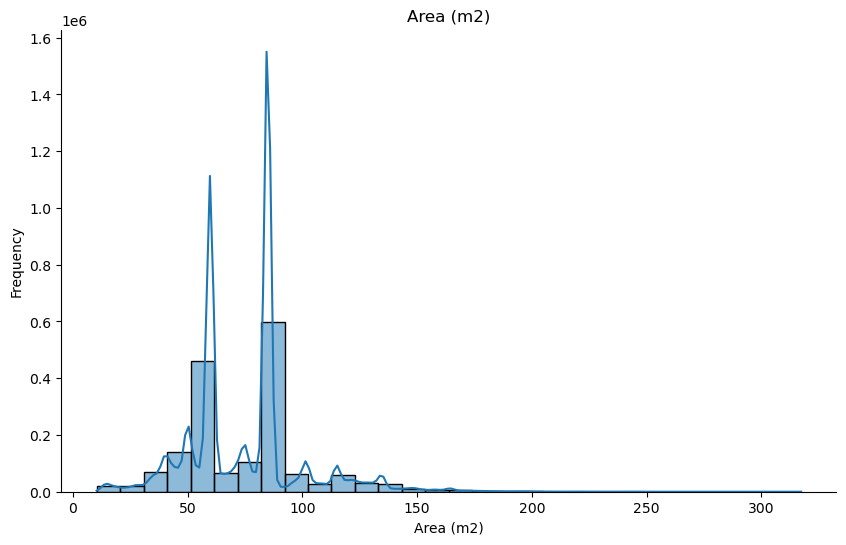

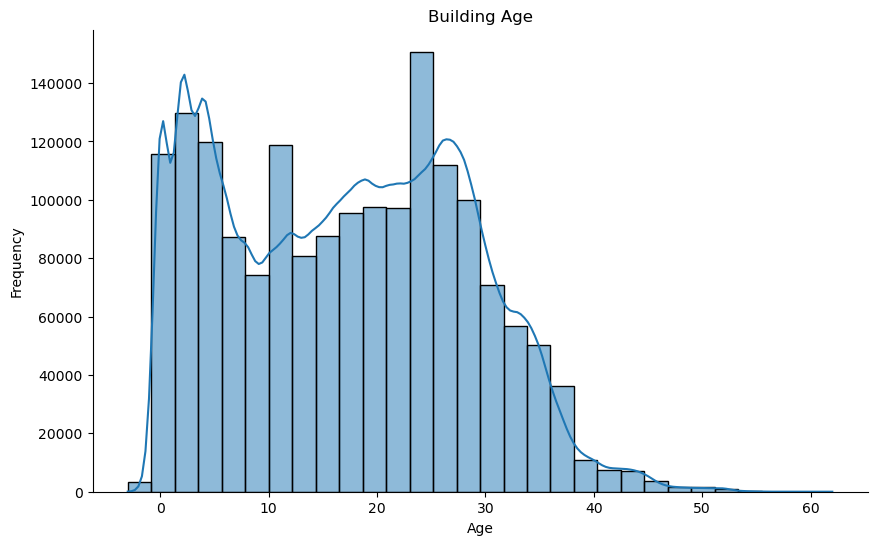

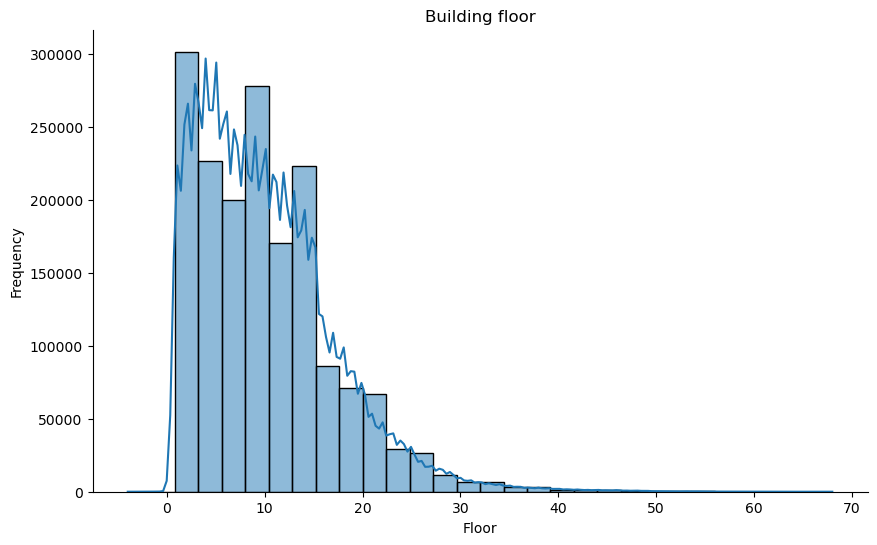

In [14]:
# 전세 실거래가 분포
plt.figure(figsize=(10, 6))
sns.histplot(train_data['deposit'], bins=30, kde=True)
plt.title('Deposit')  # 제목 키워드만 담도록 수정
plt.xlabel('Deposit')
plt.ylabel('Frequency')
sns.despine(top=True, right=True)  # 상단, 우측 경계선 제거
plt.show()

# 면적 분포
plt.figure(figsize=(10, 6))
sns.histplot(train_data['area_m2'], bins=30, kde=True)
plt.title('Area (m2)')  # 제목 키워드만 담도록 수정
plt.xlabel('Area (m2)')
plt.ylabel('Frequency')
sns.despine(top=True, right=True)  # 상단, 우측 경계선 제거
plt.show()

# 건물 나이 분포
plt.figure(figsize=(10, 6))
sns.histplot(train_data['age'], bins=30, kde=True)
plt.title('Building Age')   # 제목 키워드만 담도록 수정
plt.xlabel('Age')
plt.ylabel('Frequency')
sns.despine(top=True, right=True)  # 상단, 우측 경계선 제거
plt.show()

# 층 수 분포
plt.figure(figsize=(10, 6))
sns.histplot(train_data['floor'], bins=30, kde=True)
plt.title('Building floor') # 제목 키워드만 담도록 수정
plt.xlabel('Floor')
plt.ylabel('Frequency')
sns.despine(top=True, right=True)  # 상단, 우측 경계선 제거
plt.show()


### 제목 아예 뺀거

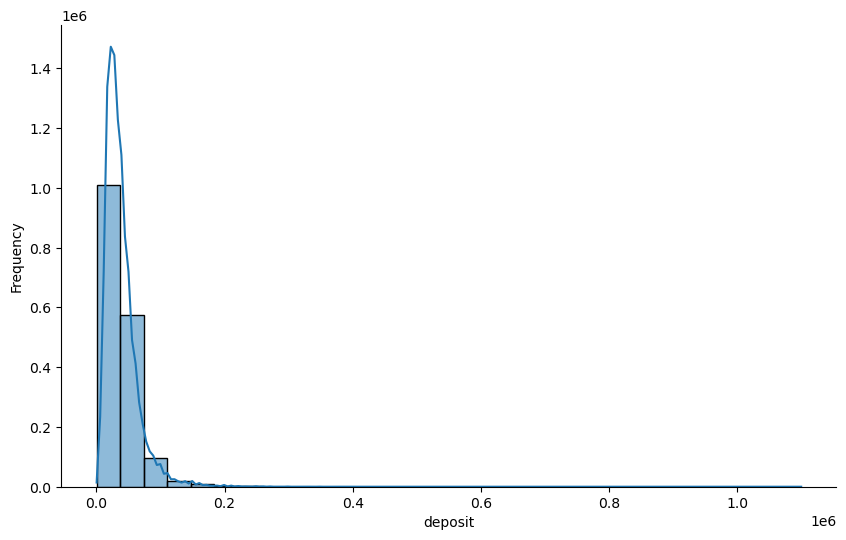

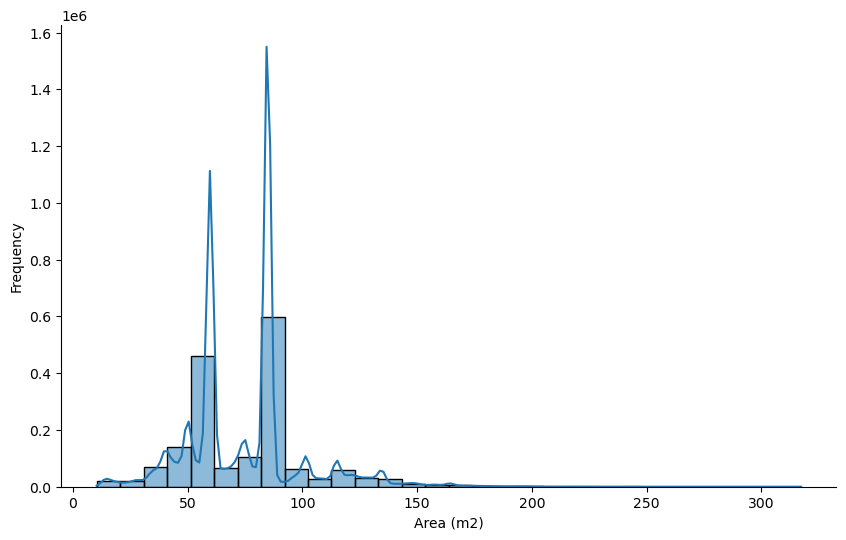

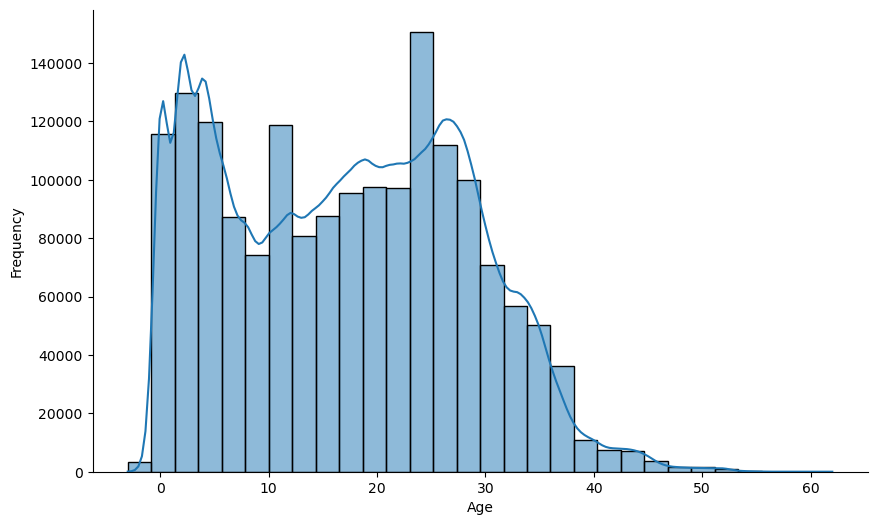

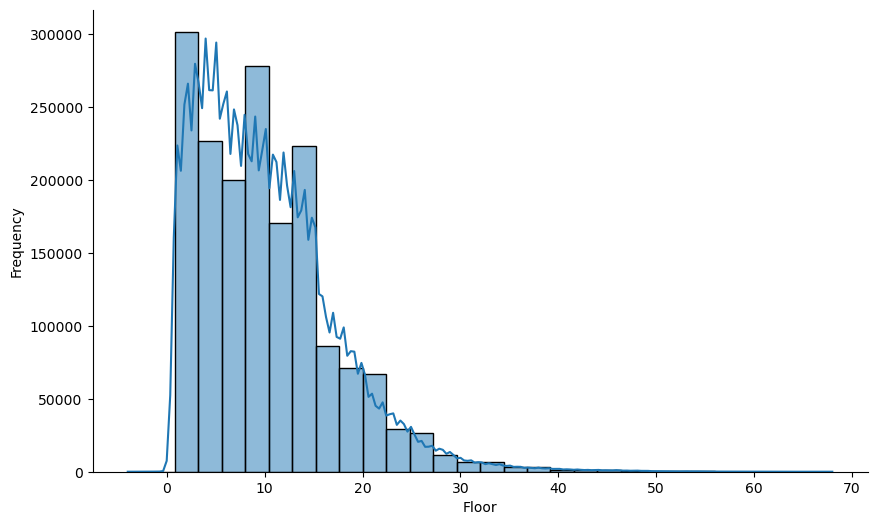

In [15]:
# 전세 실거래가 분포
plt.figure(figsize=(10, 6))
sns.histplot(train_data['deposit'], bins=30, kde=True)
plt.ylabel('Frequency')
sns.despine(top=True, right=True)  # 상단, 우측 경계선 제거
plt.show()

# 면적 분포
plt.figure(figsize=(10, 6))
sns.histplot(train_data['area_m2'], bins=30, kde=True)
plt.xlabel('Area (m2)')
plt.ylabel('Frequency')
sns.despine(top=True, right=True)  # 상단, 우측 경계선 제거
plt.show()

# 건물 나이 분포
plt.figure(figsize=(10, 6))
sns.histplot(train_data['age'], bins=30, kde=True)
plt.xlabel('Age')
plt.ylabel('Frequency')
sns.despine(top=True, right=True)  # 상단, 우측 경계선 제거
plt.show()

# 층 수 분포
plt.figure(figsize=(10, 6))
sns.histplot(train_data['floor'], bins=30, kde=True)
plt.xlabel('Floor')
plt.ylabel('Frequency')
sns.despine(top=True, right=True)  # 상단, 우측 경계선 제거
plt.show()


계약년월별 전세 실거래가 계산 (평균 및 중간 값)

### 그래프제목 'Median and Mean Deposit by Contract Year-Month'

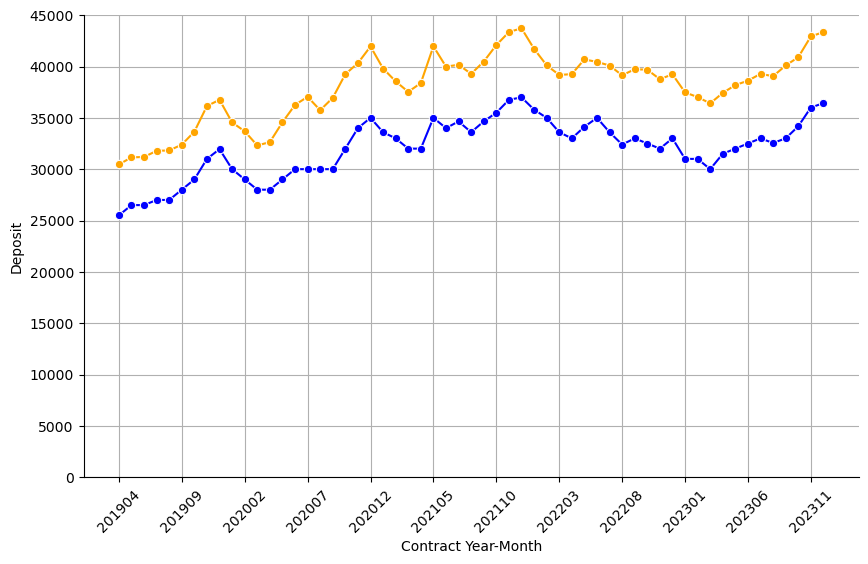

In [69]:
# 계약년월별 미디안 및 평균 전세 실거래가 계산
summary_deposit = train_data.groupby('contract_year_month')['deposit'].agg(['median', 'mean']).reset_index()
 # 아래는 'contract_year_month' 이 부분이 날짜가 아니고 int 형이어서, 그래프를 그릴 때 간격이 일정하지 않게 찍힙니다. 그래서 처리해준 부분입니다.
summary_deposit['x_range'] = range(1, len(summary_deposit) + 1)

# 그래프 그리기
plt.figure(figsize=(10, 6))
sns.lineplot(data=summary_deposit, x='x_range', y='median', marker='o', label='Median Deposit', color='blue', legend=False)
sns.lineplot(data=summary_deposit, x='x_range', y='mean', marker='o', label='Mean Deposit', color='orange', legend=False)

# x축 레이블 설정
# plt.title('Median and Mean Deposit by Contract Year-Month')   # 제목 주석처리
plt.xlabel('Contract Year-Month')
plt.ylabel('Deposit')
sns.despine(top=True, right=True)  # 상단, 우측 경계선 제거
plt.ylim(0, 45000)

plt.xticks(range(1, len(summary_deposit) + 1, 5), summary_deposit['contract_year_month'].astype(str)[::5], rotation=45)


plt.grid()
plt.show()

 층수에 따른 평균 전세 가격 확인

### 그래프제목 'Average Deposit by Floor'

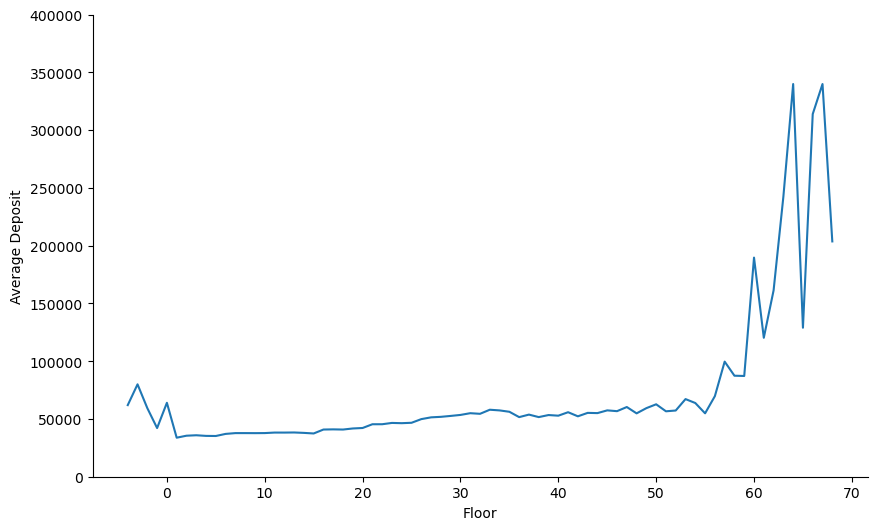

In [17]:
mean_deposit_by_floor = train_data.groupby('floor')['deposit'].mean().reset_index()

# 시각화
plt.figure(figsize=(10, 6))
sns.lineplot(data=mean_deposit_by_floor, x='floor', y='deposit')
# plt.title('Average Deposit by Floor')
plt.xlabel('Floor')
plt.ylabel('Average Deposit')
plt.ylim(0, 400000)
sns.despine(top=True, right=True)  # 상단, 우측 경계선 제거
plt.show()

면적에 따른 평균  전세 가격 확인

### 그래프제목 'Average Deposit by area_m2'

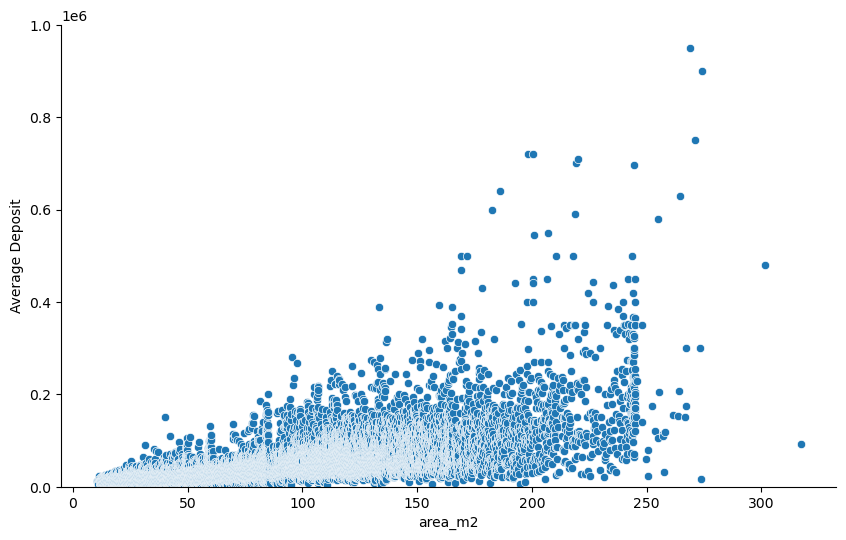

In [18]:
mean_deposit_by_floor = train_data.groupby('area_m2')['deposit'].mean().reset_index()

# 시각화
plt.figure(figsize=(10, 6))
sns.scatterplot(data=mean_deposit_by_floor, x='area_m2', y='deposit')
# plt.title('Average Deposit by area_m2')
plt.xlabel('area_m2')
plt.ylabel('Average Deposit')
plt.ylim(0, 1000000)
sns.despine(top=True, right=True)  # 상단, 우측 경계선 제거
plt.show()


계약 유형에 따른 평균 전세 가격


### 그래프제목 'Average Deposit by Contract Type'

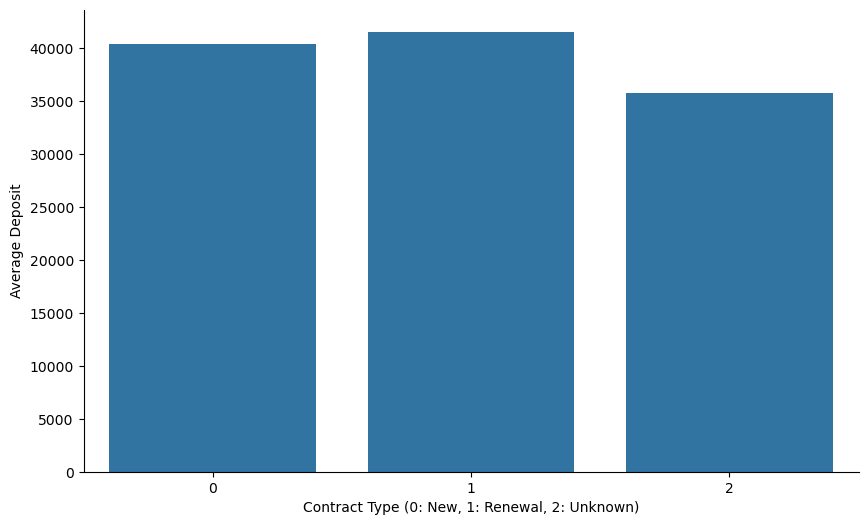

In [19]:
mean_deposit_by_contract_type = train_data.groupby('contract_type')['deposit'].mean().reset_index()

# 시각화
plt.figure(figsize=(10, 6))
sns.barplot(data=mean_deposit_by_contract_type, x='contract_type', y='deposit')
# plt.title('Average Deposit by Contract Type')
plt.xlabel('Contract Type (0: New, 1: Renewal, 2: Unknown)')
plt.ylabel('Average Deposit')
sns.despine(top=True, right=True)  # 상단, 우측 경계선 제거
plt.show()


지역별 가격(1분 걸림)

사분위수로 나누어서 지도에 그려보았는데, 특정 구간에서 높은 가격이 확인됩니다.

### 그래프이름 'Geographical Distribution of Deposit by Quartile'

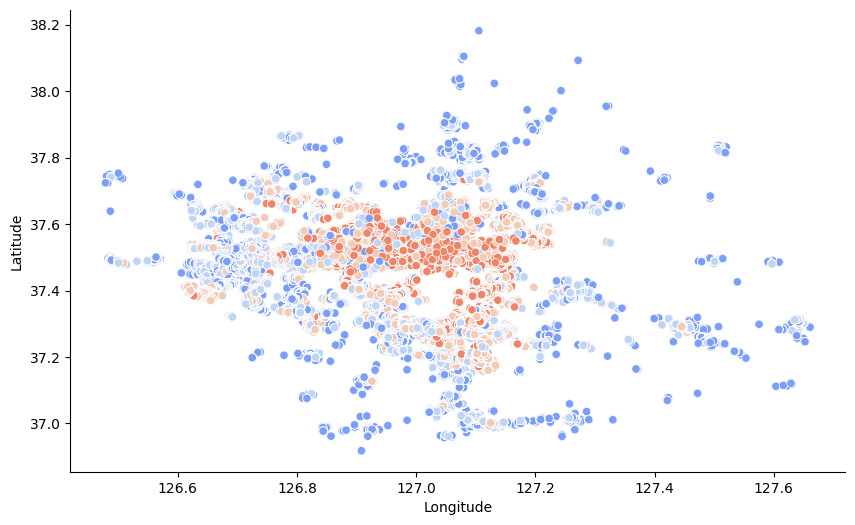

In [29]:
# 사분위수로 나누기
train_data['deposit_quartile'] = pd.qcut(train_data['deposit'], 4, labels=['1st Quartile', '2nd Quartile', '3rd Quartile', '4th Quartile'])

# 사분위수에 따른 경도위도값
plt.figure(figsize=(10, 6))
sns.scatterplot(x=train_data['longitude'], y=train_data['latitude'], hue=train_data['deposit_quartile'], palette='coolwarm', legend=False)
# plt.title('Geographical Distribution of Deposit by Quartile')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
sns.despine(top=True, right=True)  # 상단, 우측 경계선 제거
plt.show()

건물 연식에 따른 가격

### 그래프이름 'Building Age vs Deposit'

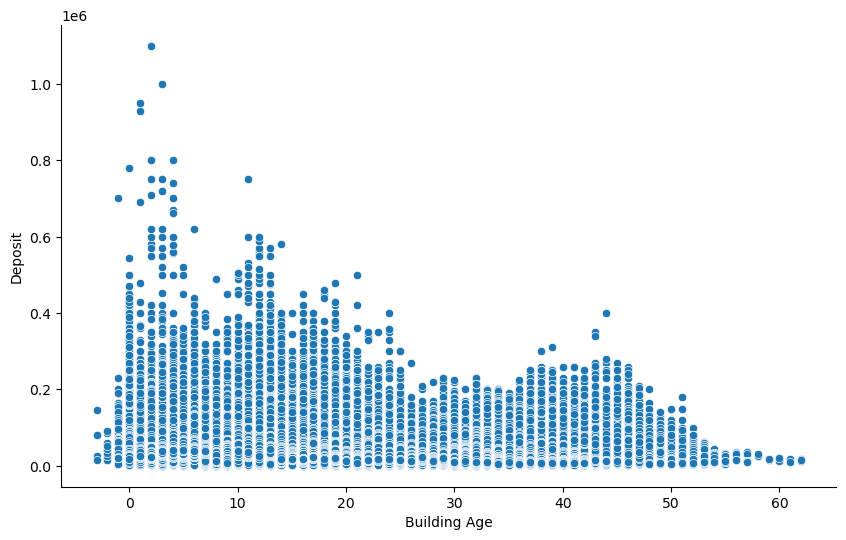

In [21]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=train_data['age'], y=train_data['deposit'])
# plt.title('Building Age vs Deposit')
plt.xlabel('Building Age')
plt.ylabel('Deposit')
sns.despine(top=True, right=True)  # 상단, 우측 경계선 제거
plt.show()


#### 금리 데이터 활용

##### 금리 데이터 매핑

In [25]:
# 이후에 금리 데이터를 매핑한 컬럼을 feature로 사용하기 위해 test 데이터셋도 처리해주었습니다. (기호에 맞게 사용)

train_data = pd.merge(train_data, interestRate,
                        left_on='contract_year_month',
                        right_on='year_month',
                        how='left')
test_data = pd.merge(test_data, interestRate,
                        left_on='contract_year_month',
                        right_on='year_month',
                        how='left')

In [26]:
train_data = train_data.drop(columns=['year_month'])
test_data = test_data.drop(columns=['year_month'])

##### 금리에 따른 실거래가 (median)
금리가 낮아지면 (이자가 낮아 대출을 많이 해서 거래가 활발해서) 거래가가 올라가고,

금리가 높아지면 거래가가 낮아질 지 궁금합니다.

### 그래프이름 'Median Deposit vs Interest Rate'

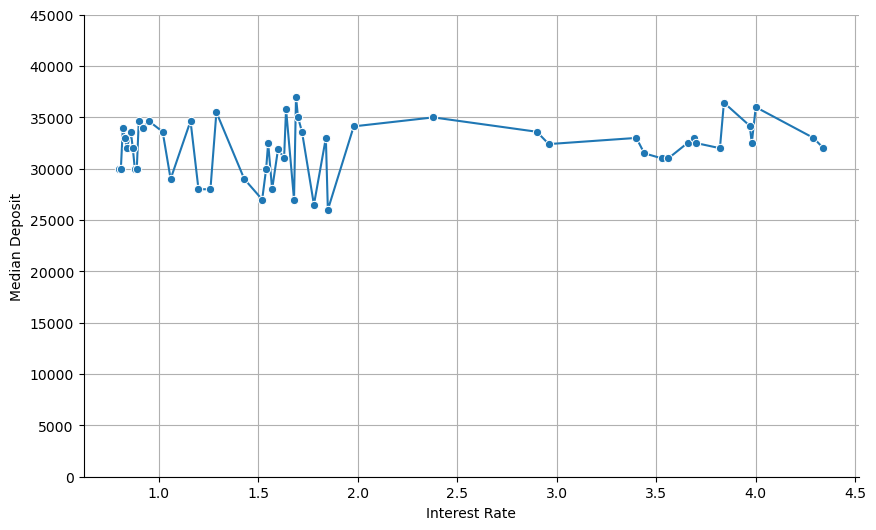

In [28]:
median_deposit = train_data.groupby('interest_rate')['deposit'].median().reset_index()

plt.figure(figsize=(10, 6))
sns.lineplot(data=median_deposit, x='interest_rate', y='deposit', marker='o')
# plt.title('Median Deposit vs Interest Rate')
plt.xlabel('Interest Rate')
plt.ylabel('Median Deposit')
plt.ylim(0, 45000)
sns.despine(top=True, right=True)  # 상단, 우측 경계선 제거
plt.grid()

plt.show()

금리가 2% 이하일 때, 매우 다양한 값 (마크가 많이 찍혔다는 것은, 많은 년월에서 2% 이하 값을 가지고 있다는 의미)

-> 금리가 2% 이상으로 올라가는 경우가 적은 것 같다!!

따라서 이런식으로 그래프를 그려서 판단하기에는, 그다지 적절하지 않은 것 같습니다.

##### 계약년월별 전세 실거래가 미디안 값과 금리

연도 별 금리를 확인하면서 각 계약년월의 전세 실거래가 미디안 값을 확인했습니다.

### 그래프이름 'Median Deposit and Interest Rate Over Time'

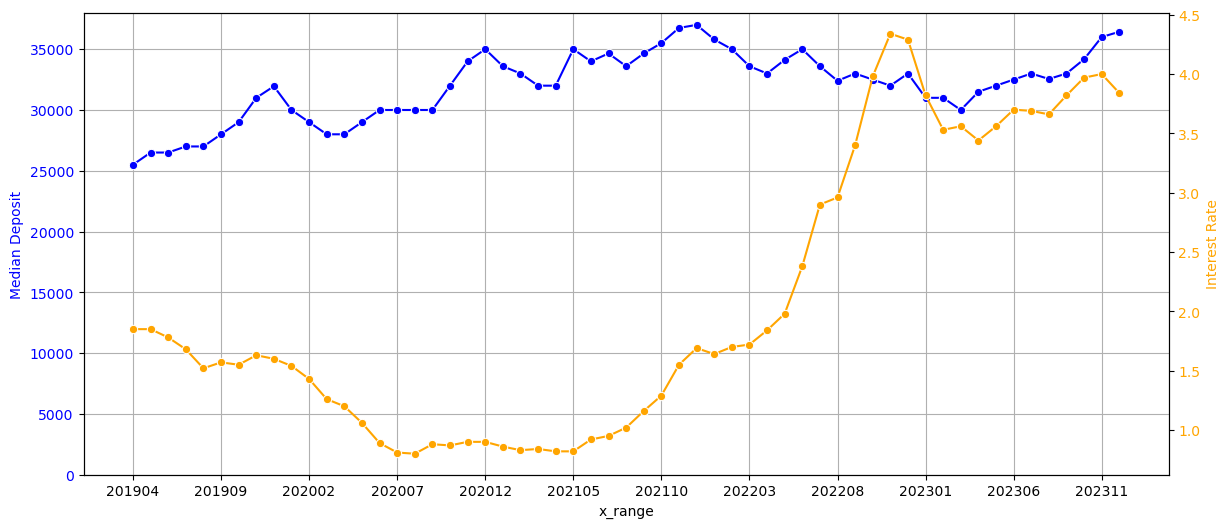

In [31]:
median_deposit = train_data.groupby('contract_year_month')['deposit'].median().reset_index()
median_deposit['x_range'] = range(1, len(median_deposit) + 1)

# 금리 데이터와 병합
merged_data = pd.merge(median_deposit, interestRate,
                        left_on='contract_year_month',
                        right_on='year_month',
                        how='left')

fig, ax1 = plt.subplots(figsize=(14, 6))

# 미디안 전세 실거래가
sns.lineplot(data=merged_data, x='x_range', y='deposit', marker='o', ax=ax1, label='Median Deposit', color='blue', legend=False)
ax1.set_ylabel('Median Deposit', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
# ax1.legend(loc='upper left')  # 범례 제거
ax1.set_ylim(0, 38000)

# 금리
ax2 = ax1.twinx()
sns.lineplot(data=merged_data, x='x_range', y='interest_rate', marker='o', ax=ax2, label='Interest Rate', color='orange', legend=False)
ax2.set_ylabel('Interest Rate', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')
# ax2.legend(loc='upper right')  # 범례 제거

# plt.title('Median Deposit and Interest Rate Over Time')
plt.xlabel('Contract Year-Month')
plt.xticks(range(1, len(merged_data) + 1, 5), merged_data['contract_year_month'].astype(str)[::5], rotation=45)

ax1.grid()
plt.show()

금리가 낮아질 때 주택 가격이 오르고, 높아질 때 낮아지는 그런 경향성이 보이는 것도 같지만 

그렇게 판단하기에 그래프가 부정확하고, 다른 여러 요인을 생각해야합니다.

#### 지하철 데이터 활용

가까운 지하철과의 거리 계산

In [32]:
#Version 1

# 유클리드 거리로 계산이 되기 때문에 정확하지 않은 방법이지만,
# 나온 distances에 111을 곱하면 킬로미터 단위로 변환이 가능하다고 합니다.

def calculate_nearest_subway_distance(apart_coords, subway_coords):
    tree = cKDTree(subway_coords)
    # 모든 아파트에 대해 최근접 이웃 검색
    distances, _ = tree.query(apart_coords)
    return distances*111

# 지하철 역 데이터의 경위도 배열 생성
subway_coords = subwayInfo[['latitude', 'longitude']].to_numpy()

# 각 아파트에 대해 가까운 지하철역 거리 추가
apart_coords = train_data[['latitude', 'longitude']].to_numpy()
train_data['nearest_subway_distance_2'] = calculate_nearest_subway_distance(apart_coords, subway_coords)

apart_coords = test_data[['latitude', 'longitude']].to_numpy()
test_data['nearest_subway_distance_2'] = calculate_nearest_subway_distance(apart_coords, subway_coords)




In [33]:
# Version 2

# 이 함수는 다른 추가 데이터 중 거리를 계산할 때에도 사용됩니다!!! (공원, 학교 데이터)
def haversine_vectorized(lonlat1, lonlat2):
    # 지구 반지름 (km)
    R = 6371.0

    # 경도와 위도 분리 (radian으로 변환)
    lon1, lat1 = np.radians(lonlat1[:, 0]), np.radians(lonlat1[:, 1])
    lon2, lat2 = np.radians(lonlat2[:, 0]), np.radians(lonlat2[:, 1])

    # 차이 계산
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    # Haversine 공식 적용
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))

    # 결과적으로 거리는 R * c
    distance = R * c
    return distance

def calculate_nearest_subway_distance(apart_coords, subway_coords):
    tree = cKDTree(subway_coords)
    # 모든 아파트에 대해 최근접 이웃 검색
    distances, indices = tree.query(apart_coords)

    return haversine_vectorized(tree.data[indices], apart_coords)


# 각 아파트에 대해 가까운 지하철역 거리 추가
apart_coords = train_data[['latitude', 'longitude']].to_numpy()
train_data['nearest_subway_distance'] = calculate_nearest_subway_distance(apart_coords, subway_coords)

apart_coords = test_data[['latitude', 'longitude']].to_numpy()
test_data['nearest_subway_distance'] = calculate_nearest_subway_distance(apart_coords, subway_coords)

In [34]:
train_data

,index,area_m2,contract_year_month,contract_day,contract_type,floor,built_year,latitude,longitude,age,deposit,deposit_quartile,interest_rate,nearest_subway_distance_2,nearest_subway_distance
0,0,84.9981,201906,25,2,9,2019,37.054314,127.045216,0,17000.0,1st Quartile,1.78,0.877958,0.857916
1,1,84.9981,202003,26,2,20,2019,37.054314,127.045216,1,23000.0,2nd Quartile,1.26,0.877958,0.857916
2,2,84.9981,202003,28,2,8,2019,37.054314,127.045216,1,23000.0,2nd Quartile,1.26,0.877958,0.857916
3,3,59.3400,201907,15,2,1,1986,36.964647,127.055847,33,5000.0,1st Quartile,1.68,4.354959,3.698483
4,4,59.8100,201904,12,2,6,1995,36.972390,127.084514,24,1800.0,1st Quartile,1.85,2.036565,1.231527
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1717606,1801223,114.8126,202311,25,0,5,2010,37.528394,126.659398,13,39000.0,3rd Quartile,4.00,1.839210,1.811903
1717607,1801224,101.9088,202311,28,0,6,2010,37.528394,126.659398,13,38000.0,3rd Quartile,4.00,1.839210,1.811903
1717608,1801225,114.7900,202312,3,0,19,2010,37.528394,126.659398,13,37000.0,3rd Quartile,3.84,1.839210,1.811903
1717609,1801226,101.9088,202312,4,1,15,2010,37.528394,126.659398,13,34400.0,3rd Quartile,3.84,1.839210,1.811903


거리 구간 별 행의 개수 (km 단위)

In [35]:
bins = [i for i in range(31)]
labels = [f"{i}~{i+1}" for i in range(30)]

train_data['distance_category'] = pd.cut(train_data['nearest_subway_distance'], bins=bins, labels=labels, right=False)

category_counts = train_data['distance_category'].value_counts().sort_index()

print(category_counts)


distance_category
0~1      1142531
1~2       281506
2~3        96818
3~4        82413
4~5        48034
5~6        19260
6~7        11338
7~8         3892
8~9         3743
9~10        2065
10~11       1141
11~12        837
12~13       1293
13~14       1526
14~15       2912
15~16       6837
16~17       7158
17~18       2151
18~19        328
19~20        368
20~21         84
21~22          0
22~23        462
23~24        910
24~25          0
25~26          4
26~27          0
27~28          0
28~29          0
29~30          0
Name: count, dtype: int64


지하철역과의 거리에 따른 중간 실거래가

### 'Deposit by Nearest Subway Distance (0-30km)'

/tmp/ipykernel_1368661/2674198038.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median_deposit_by_distance = train_data.groupby('nearest_subway_distance_group')['deposit'].median().reset_index()


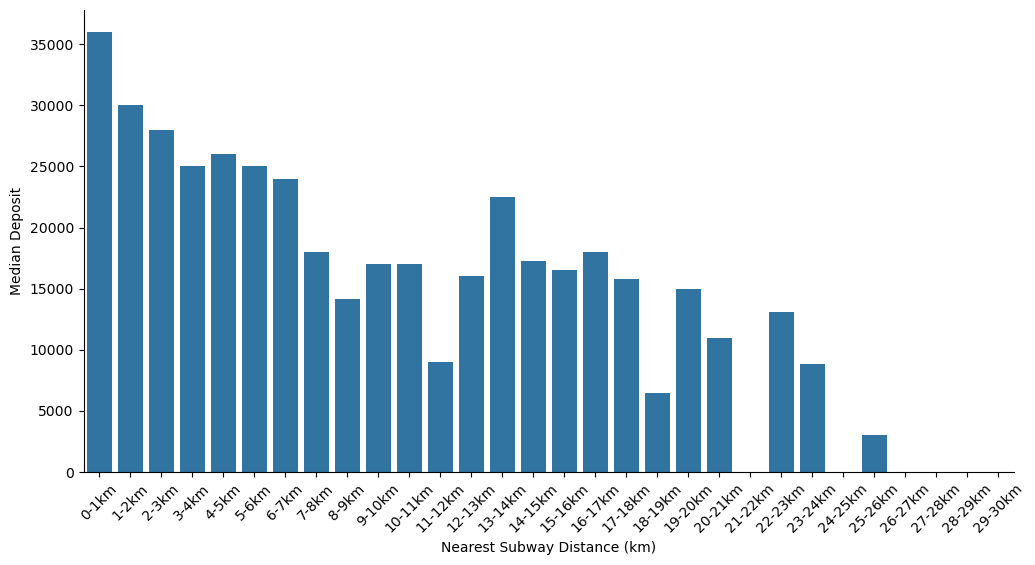

In [36]:
# 거리 구간 만들기 (0km에서 30km까지)
train_data['nearest_subway_distance_group'] = pd.cut(
    train_data['nearest_subway_distance'],  # 킬로미터 단위 그대로 사용
    bins=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
          11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
          21, 22, 23, 24, 25, 26, 27, 28, 29, 30],
    labels=[
        '0-1km', '1-2km', '2-3km', '3-4km', '4-5km',
        '5-6km', '6-7km', '7-8km', '8-9km', '9-10km',
        '10-11km', '11-12km', '12-13km', '13-14km',
        '14-15km', '15-16km', '16-17km', '17-18km',
        '18-19km', '19-20km', '20-21km', '21-22km',
        '22-23km', '23-24km', '24-25km', '25-26km',
        '26-27km', '27-28km', '28-29km', '29-30km'
    ]
)

# 거리 구간에 따른 전세 가격 중간값
median_deposit_by_distance = train_data.groupby('nearest_subway_distance_group')['deposit'].median().reset_index()

# 시각화
plt.figure(figsize=(12, 6))
sns.barplot(data=median_deposit_by_distance, x='nearest_subway_distance_group', y='deposit')
# plt.title('Deposit by Nearest Subway Distance (0-30km)')
plt.xlabel('Nearest Subway Distance (km)')
plt.ylabel('Median Deposit')
plt.xticks(rotation=45)
sns.despine(top=True, right=True)  # 상단, 우측 경계선 제거
plt.show()


#### 학교 정보 활용

### 그래프제목 'School Level Distribution'

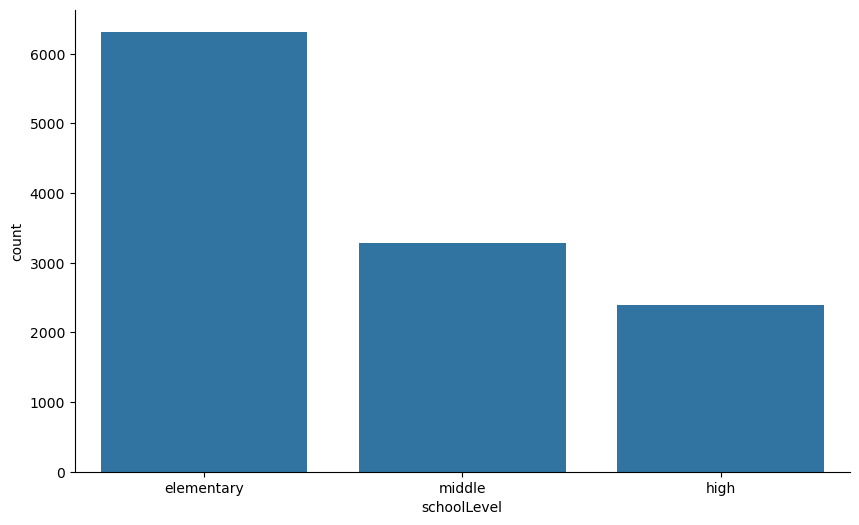

In [38]:
# 학교 종류별 카운트

plt.figure(figsize=(10, 6))
sns.countplot(x='schoolLevel', data=schoolInfo)
# plt.title('School Level Distribution')
sns.despine(top=True, right=True)  # 상단, 우측 경계선 제거
plt.show()

In [41]:
def calculate_nearest_school_distance(apart_coords, school_info):
    # 학교 레벨별로 거리 계산을 위한 빈 딕셔너리 초기화
    nearest_distances = {}

    # 각 학교 레벨에 대한 거리 계산
    for level in school_info['schoolLevel'].unique():
        level_coords = school_info[school_info['schoolLevel'] == level][['latitude', 'longitude']].to_numpy()

        if level_coords.shape[0] > 0:
            tree = cKDTree(level_coords)
            distances, indices = tree.query(apart_coords)

            nearest_distances[level] = haversine_vectorized(tree.data[indices], apart_coords)

    return nearest_distances

# 아파트 데이터의 경위도 배열 생성 (넘파이 쓰는 이유는 더 빠른 연산을 위함)
apart_coords_train = train_data[['latitude', 'longitude']].to_numpy()
apart_coords_test = test_data[['latitude', 'longitude']].to_numpy()


# 각 아파트에 대해 가까운 학교 거리 추가
nearest_school_distances = calculate_nearest_school_distance(apart_coords_train, schoolInfo)
for level in nearest_school_distances:
    train_data[f'nearest_{level}_distance'] = nearest_school_distances[level]

nearest_school_distances = calculate_nearest_school_distance(apart_coords_test, schoolInfo)
for level in nearest_school_distances:
    test_data[f'nearest_{level}_distance'] = nearest_school_distances[level]


#### 공원 정보 활용

주변의 큰 공원이 있으면 아파트 가격이 높을까?

In [42]:
# 공원에 대한 최근접 거리 및 면적 계산
def calculate_nearest_park(apart_coords, park_info):
    tree = cKDTree(park_coords)
    distances, indices = tree.query(apart_coords)

    # 가장 가까운 공원의 면적 반환
    nearest_park_areas = park_info['area'].iloc[indices].values

    nearest_park_distances = haversine_vectorized(tree.data[indices], apart_coords)

    # 거리 반환 (미터 단위로 변환)
    return nearest_park_distances, nearest_park_areas

# 아파트 데이터와 공원 데이터의 경위도 배열 생성
apart_coords_train = train_data[['latitude', 'longitude']].to_numpy()
apart_coords_test = test_data[['latitude', 'longitude']].to_numpy()
park_coords = parkInfo[['latitude', 'longitude']].to_numpy()

# 각 아파트에 대해 가까운 공원 면적과 거리 추가
train_data['nearest_park_distance'], train_data['nearest_park_area'] = calculate_nearest_park(apart_coords_train, parkInfo)
test_data['nearest_park_distance'], test_data['nearest_park_area'] = calculate_nearest_park(apart_coords_test, parkInfo)


엥..ㅎㅎ

### 'Apartment Deposit vs Nearest Park Area'

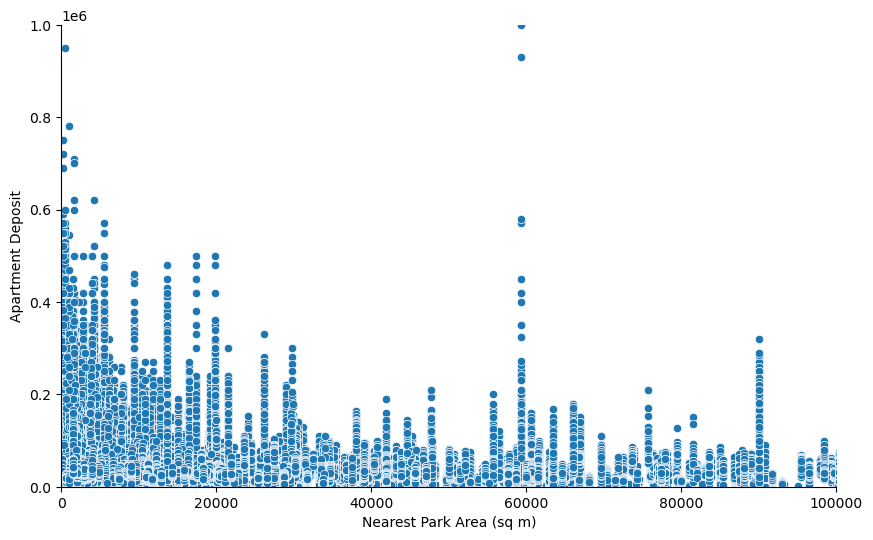

In [43]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=train_data, x='nearest_park_area', y='deposit')
# plt.title('Apartment Deposit vs Nearest Park Area')
plt.xlabel('Nearest Park Area (sq m)')
plt.ylabel('Apartment Deposit')
plt.xlim(0, 100000)
plt.ylim(0, 1000000)
sns.despine(top=True, right=True)  # 상단, 우측 경계선 제거
plt.show()

# cluster 변수 생성 하고 분석

## 방법1. DBSCAN 기반 클러스터링

### train 데이터와 holdout 데이터를 나눈 뒤 train 데이터에 대해 클러스터링

In [44]:
holdout_start = 202307
holdout_end = 202312
# holdout_data = train_data[(train_data['contract_year_month'] >= holdout_start) & (train_data['contract_year_month'] <= holdout_end)]
tmp_data = train_data[~((train_data['contract_year_month'] >= holdout_start) & (train_data['contract_year_month'] <= holdout_end))]

# StandardScaler 인스턴스 생성
scaler = StandardScaler()

# train_data의 위도, 경도 스케일링 및 DataFrame으로 변환
train_data_scaled = pd.DataFrame(
    scaler.fit_transform(tmp_data[['latitude', 'longitude']]),
    columns=['latitude', 'longitude'],
    index=tmp_data.index
)

### 'Train Data with DBSCAN Clusters'

### 색상 변경

/tmp/ipykernel_1368661/3617597579.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_data['cluster'] = dbscan.fit_predict(train_data_scaled[['latitude', 'longitude']])


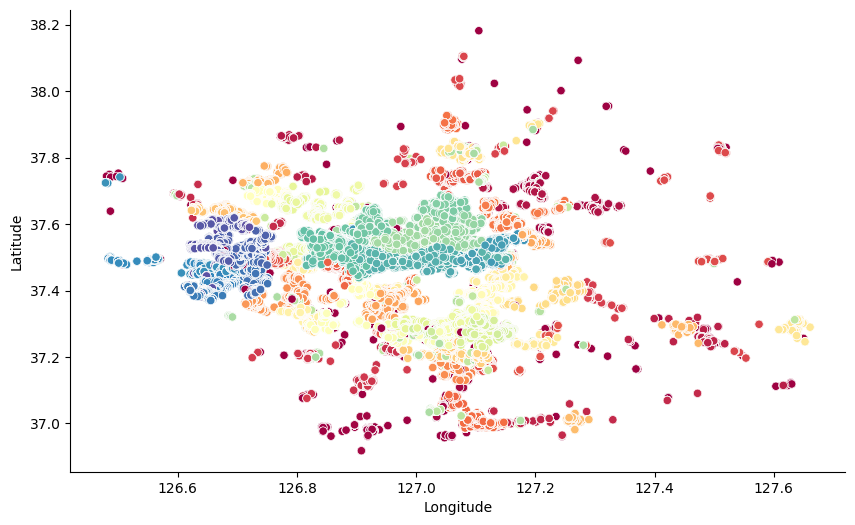

In [48]:
# DBSCAN 클러스터링 수행
dbscan = DBSCAN(eps=0.0175, min_samples=15)
# 클러스터 결과를 원본 데이터와 동일한 인덱스로 추가
tmp_data['cluster'] = dbscan.fit_predict(train_data_scaled[['latitude', 'longitude']])

# 클러스터링 결과 확인 (train 데이터 샘플에 대해 시각화)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='longitude', y='latitude', hue='cluster', data=tmp_data, palette='Spectral', legend=False)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
sns.despine(top=True, right=True)  # 상단, 우측 경계선 제거
plt.show()

### 기존 색상 그래프

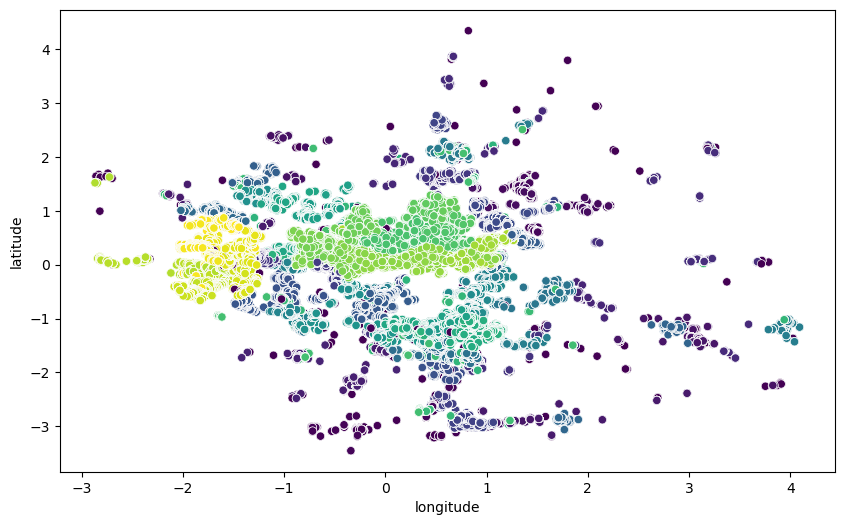

In [49]:
# DBSCAN 클러스터링 수행
dbscan = DBSCAN(eps=0.0175, min_samples=15)
train_data_scaled['cluster'] = dbscan.fit_predict(train_data_scaled[['latitude', 'longitude']])

# 클러스터링 결과 확인 (train 데이터 샘플에 대해 시각화)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='longitude', y='latitude', hue='cluster', data=train_data_scaled, palette='viridis', legend=False)
# plt.title('Train Data with DBSCAN Clusters')
plt.show()

In [50]:
train_data_scaled['cluster'].value_counts()

cluster
1645    53930
1567    46237
1404    39293
1410    29596
1713    24950
        ...  
1886       15
1601       15
1467       15
1406       15
221        15
Name: count, Length: 1987, dtype: int64

In [51]:
(train_data_scaled['cluster'].value_counts() > 100).value_counts()

count
True     1474
False     513
Name: count, dtype: int64

### 'Top {k} Clusters and Noise Points (-1)'

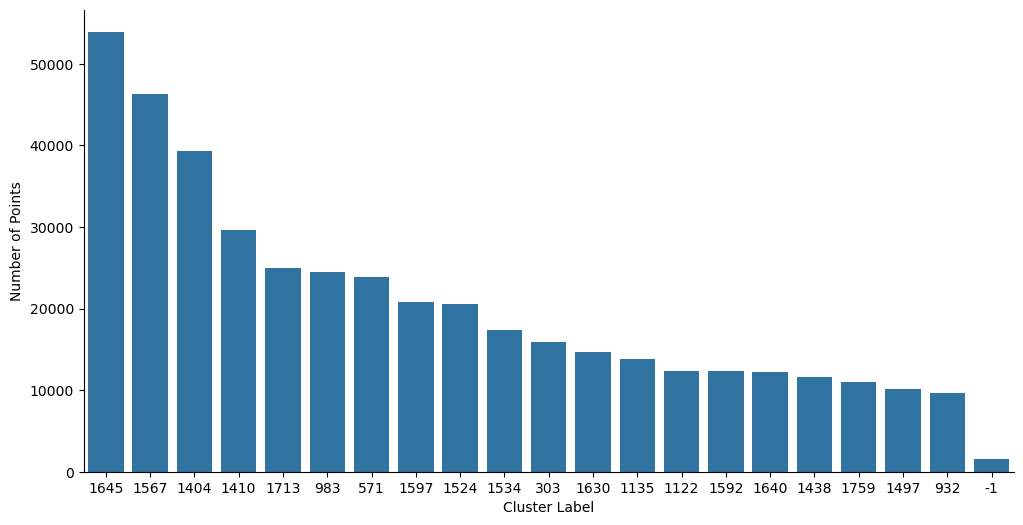

In [53]:
# 클러스터 크기 분포 확인
cluster_counts = train_data_scaled['cluster'].value_counts()

# 상위 k개 클러스터와 -1 클러스터 선택
k = 20
top_clusters = cluster_counts.nlargest(k)
# -1이 상위 k개에 포함되지 않을 때에 포함시킴
if -1 not in top_clusters.index:
    top_clusters = pd.concat([top_clusters, pd.Series({-1: cluster_counts.get(-1, 0)})])

# 바 플롯 생성
plt.figure(figsize=(12, 6))
sns.barplot(x=top_clusters.index.astype(str), y=top_clusters.values)
# plt.title(f'Top {k} Clusters and Noise Points (-1)')
plt.xlabel('Cluster Label')
plt.ylabel('Number of Points')
sns.despine(top=True, right=True)  # 상단, 우측 경계선 제거
plt.show()

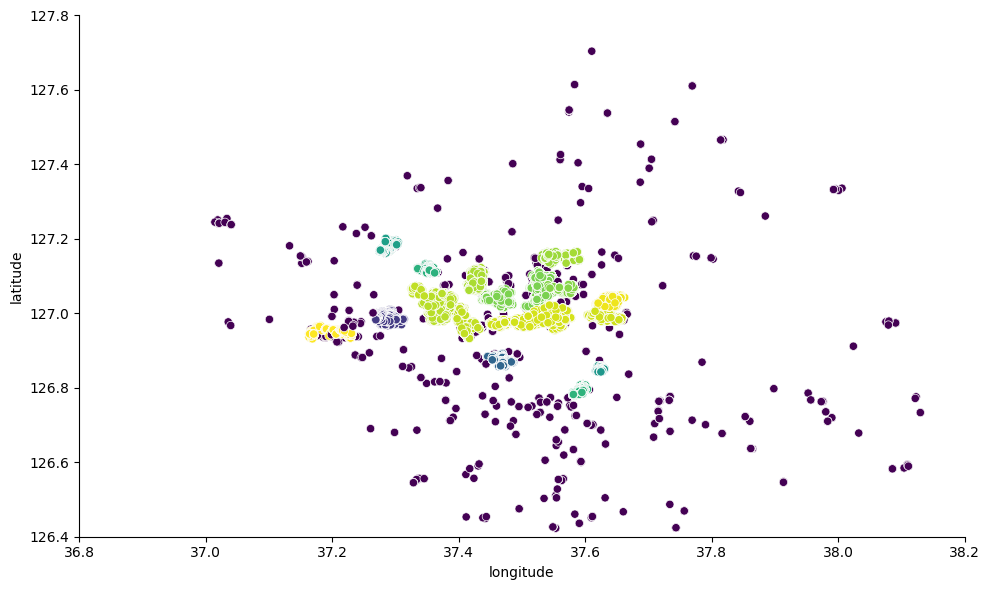

In [56]:
# 상위 k개 클러스터와 노이즈 포인트 선택
k = 20
top_k_clusters = cluster_counts.nlargest(k).index.tolist()
# -1이 상위 k개에 포함되지 않을 때에 포함시킴
if -1 not in top_k_clusters:
    top_k_clusters.append(-1)

# 선택된 클러스터의 데이터만 필터링
plot_data = train_data_scaled.copy()
plot_data[['longitude', 'latitude']] = scaler.inverse_transform(plot_data[['longitude', 'latitude']])
selected_data = plot_data[plot_data['cluster'].isin(top_k_clusters)]

# 스캐터 플롯 생성
plt.figure(figsize=(10, 6))
# x축(longitude)과 y축(latitude) 범위 설정
plt.xlim(36.8, 38.2)    # latitude 범위
plt.ylim(126.4, 127.8)  # longitude 범위
sns.scatterplot(x='longitude', y='latitude', hue='cluster', data=selected_data, palette='viridis', legend=False)

# plt.title(f'Geographic Distribution of Top {k} Clusters and Noise Points')
# plt.legend()
plt.tight_layout()
sns.despine(top=True, right=True)  # 상단, 우측 경계선 제거
plt.show()


### 'Geographic Distribution of Top {k} Clusters without Noise Points' K=1,2,3,4,5

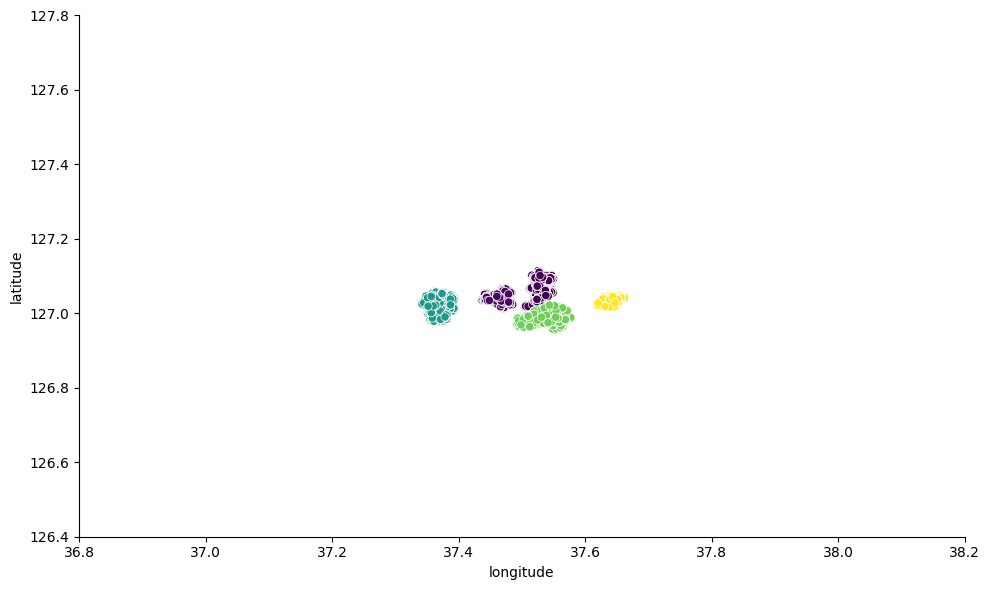

In [60]:
# 상위 k개 클러스터와 노이즈 포인트 선택
k = 5
top_k_clusters = cluster_counts.nlargest(k).index.tolist()
# -1이 상위 k개에 포함되었을 때 제외시킴
if -1 in top_k_clusters:
    top_k_clusters.remove(-1)

# 선택된 클러스터의 데이터만 필터링
plot_data = train_data_scaled.copy()
plot_data[['longitude', 'latitude']] = scaler.inverse_transform(plot_data[['longitude', 'latitude']])
selected_data = plot_data[plot_data['cluster'].isin(top_k_clusters)]

# 스캐터 플롯 생성
plt.figure(figsize=(10, 6))
# x축(longitude)과 y축(latitude) 범위 설정
plt.xlim(36.8, 38.2)    # latitude 범위
plt.ylim(126.4, 127.8)  # longitude 범위
sns.scatterplot(x='longitude', y='latitude', hue='cluster', data=selected_data, palette='viridis', legend=False)

# plt.title(f'Geographic Distribution of Top {k} Clusters without Noise Points')
# plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
sns.despine(top=True, right=True)  # 상단, 우측 경계선 제거
plt.tight_layout()
plt.show()

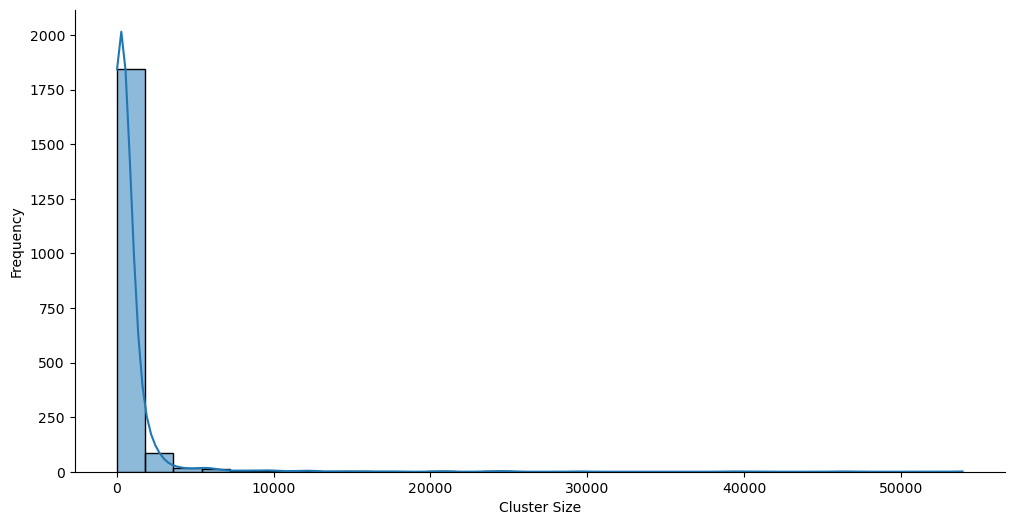

In [61]:
# 노이즈 포인트를 제외한 클러스터 크기 분포
cluster_sizes = cluster_counts[cluster_counts.index != -1]

plt.figure(figsize=(12, 6))
sns.histplot(cluster_sizes, bins=30, kde=True)
# plt.title('Histogram of Cluster Sizes (Excluding Noise Points)')
plt.xlabel('Cluster Size')
plt.ylabel('Frequency')
sns.despine(top=True, right=True)  # 상단, 우측 경계선 제거
plt.show()

/tmp/ipykernel_1368661/2643987270.py:3: DeprecationWarning: Please import `QhullError` from the `scipy.spatial` namespace; the `scipy.spatial.qhull` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.spatial.qhull import QhullError
/tmp/ipykernel_1368661/2643987270.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cluster_densities = train_data_scaled.groupby('cluster').apply(calculate_density)


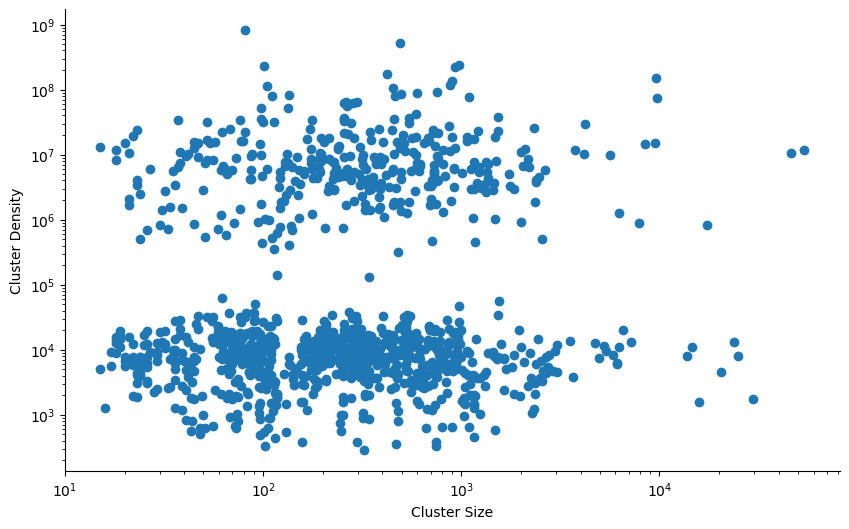

In [62]:
from scipy.spatial import ConvexHull
import numpy as np
from scipy.spatial.qhull import QhullError

def calculate_density(group):
    if len(group) < 3:  # 포인트가 3개 미만이면 밀도를 0으로 처리
        return 0
    try:
        hull = ConvexHull(group[['longitude', 'latitude']])
        return len(group) / hull.area
    except QhullError:  # ConvexHull 계산 중 오류 발생 시
        # 포인트들의 경계 상자(bounding box) 면적을 사용
        min_lon, max_lon = group['longitude'].min(), group['longitude'].max()
        min_lat, max_lat = group['latitude'].min(), group['latitude'].max()
        area = (max_lon - min_lon) * (max_lat - min_lat)
        return len(group) / area if area > 0 else 0

# 클러스터별 밀도 계산
cluster_densities = train_data_scaled.groupby('cluster').apply(calculate_density)
cluster_sizes = train_data_scaled['cluster'].value_counts()

# 노이즈 포인트 제외
cluster_densities = cluster_densities[cluster_densities.index != -1]
cluster_sizes = cluster_sizes[cluster_sizes.index != -1]

# 결과 시각화
plt.figure(figsize=(10, 6))
plt.scatter(cluster_sizes, cluster_densities)
plt.xlabel('Cluster Size')
plt.ylabel('Cluster Density')
# plt.title('Cluster Size vs Density')
plt.xscale('log')  # x축을 로그 스케일로 변경
plt.yscale('log')  # y축을 로그 스케일로 변경
sns.despine(top=True, right=True)  # 상단, 우측 경계선 제거
plt.show()

### 전체 데이터로 클러스터 라벨 생성

/data/ephemeral/home/miniconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


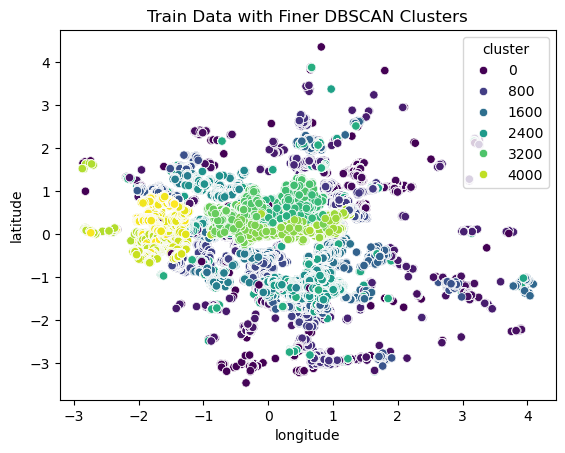

In [63]:
# DBSCAN 클러스터링 수행 (더 촘촘하게)
dbscan = DBSCAN(eps=0.0125, min_samples=5)  # eps 값을 줄여 더 작은 반경의 클러스터링 수행
train_data_scaled['cluster'] = dbscan.fit_predict(train_data_scaled[['latitude', 'longitude']])

# 클러스터링 결과 확인 (train 데이터 샘플에 대해 시각화)
sns.scatterplot(x='longitude', y='latitude', hue='cluster', data=train_data_scaled, palette='viridis')
# plt.title('Train Data with Finer DBSCAN Clusters')
sns.despine(top=True, right=True)  # 상단, 우측 경계선 제거
plt.show()

## 방법3. 거리 기반의 K-Means 클러스터링

### Train Data with K-Means Clusters (K=25)

전체 훈련 데이터를 이용해 K-Means 클러스터링 진행 

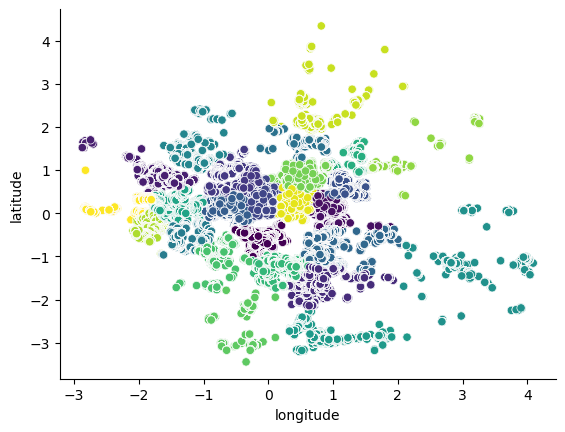

In [64]:
# StandardScaler를 사용해 스케일링
scaler = StandardScaler()

# train_data와 test_data의 위도, 경도 스케일링
train_data_scaled = scaler.fit_transform(train_data[['latitude', 'longitude']])
test_data_scaled = scaler.transform(test_data[['latitude', 'longitude']])

# 스케일링된 데이터를 DataFrame으로 변환
train_data_scaled_df = pd.DataFrame(train_data_scaled, columns=['latitude', 'longitude'])
test_data_scaled_df = pd.DataFrame(test_data_scaled, columns=['latitude', 'longitude'])

# KMeans 클러스터링 수행 (K=25로 설정하여 25개의 클러스터 생성)
kmeans = KMeans(n_clusters=25, random_state=42)
train_data_scaled_df['cluster'] = kmeans.fit_predict(train_data_scaled_df)

# # KMeans 클러스터링 수행 (K=100으로 설정하여 100개의 클러스터 생성)
# kmeans = KMeans(n_clusters=100, random_state=42)
# train_data_scaled_df['cluster'] = kmeans.fit_predict(train_data_scaled_df)

# 클러스터링 결과 시각화
sns.scatterplot(x='longitude', y='latitude', hue='cluster', data=train_data_scaled_df, palette='viridis', legend=False)
# plt.title('Train Data with K-Means Clusters (K=25)')
sns.despine(top=True, right=True)  # 상단, 우측 경계선 제거
plt.show()

# # 클러스터링 결과 시각화
# sns.scatterplot(x='longitude', y='latitude', hue='cluster', data=train_data_scaled_df, palette='viridis')
# # plt.title('Train Data with K-Means Clusters (K=100)')
# plt.show()

클러스터가 잘 된 것을 확인. 기존의 train_data에도 반영

In [65]:
train_data['cluster'] = train_data_scaled_df['cluster']

(2) cluster 값을 위도(longitude), 경도(latitude)를 기반으로 예측하는 지도 학습모델을 훈련
- 모든 평가지표 값이 1.00이라는 말도 안되는 수치가 나옴
- 사실 cluster 변수 생성과정을 고려하면 그럴 만도 함 

In [66]:
# train 데이터를 train/validation으로 분할 (80% train, 20% validation)
X_train, X_valid, y_train, y_valid = train_test_split(
    train_data_scaled_df[['latitude', 'longitude']],
    train_data_scaled_df['cluster'], 
    test_size=0.2,
    random_state=42
)

# RandomForest 모델 생성
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# 모델 학습
rf_classifier.fit(X_train, y_train)

# validation 데이터에 대한 예측
y_pred = rf_classifier.predict(X_valid)

# 검증 데이터에 대한 정확도 확인
accuracy = accuracy_score(y_valid, y_pred)
print(f"Validation Accuracy: {accuracy:.2f}")

# 더 상세한 성능 지표 확인 (클래스별 precision, recall, f1-score 등)
print(classification_report(y_valid, y_pred))

Validation Accuracy: 1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19002
           1       1.00      1.00      1.00     20771
           2       1.00      1.00      1.00      9508
           3       1.00      1.00      1.00     19117
           4       1.00      1.00      1.00     21521
           5       1.00      1.00      1.00     18975
           6       1.00      1.00      1.00     16566
           7       1.00      1.00      1.00     26878
           8       1.00      1.00      1.00     24282
           9       1.00      1.00      1.00      6300
          10       1.00      1.00      1.00      7825
          11       1.00      1.00      1.00     16233
          12       1.00      1.00      1.00      2772
          13       1.00      1.00      1.00      8291
          14       1.00      1.00      1.00     17505
          15       1.00      1.00      1.00      2636
          16       1.00      1.00      1.00     14111
 

(3) 지도 test 데이터의 cluster 변수 예측

### 'Test Data with Predicted Clusters'

/data/ephemeral/home/miniconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


    latitude   longitude  cluster
0  36.965423  127.048779       13
1  36.963105  127.040678       13
2  36.957089  127.047449       13
3  36.957089  127.047449       13
4  36.957089  127.047449       13


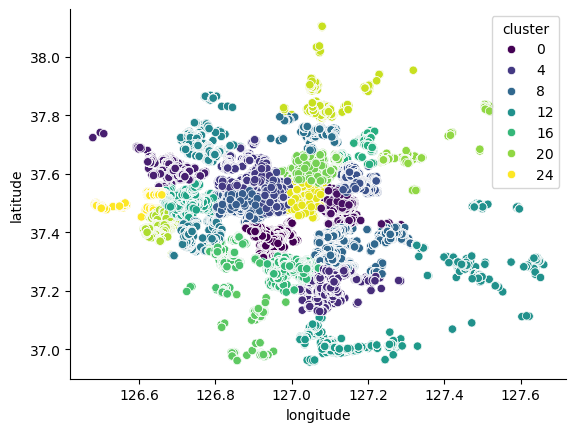

In [67]:
# test 데이터에 대해 클러스터 예측 (스케일링 적용 후)
X_test_scaled = scaler.transform(test_data[['latitude', 'longitude']])

# RandomForest를 사용하여 클러스터 예측
test_data['cluster'] = rf_classifier.predict(X_test_scaled)

# 결과 확인
print(test_data[['latitude', 'longitude', 'cluster']].head())

# 예측된 클러스터를 시각적으로 확인
sns.scatterplot(x='longitude', y='latitude', hue='cluster', data=test_data, palette='viridis')
# plt.title('Test Data with Predicted Clusters')
sns.despine(top=True, right=True)  # 상단, 우측 경계선 제거
plt.show()

# 대회에 필요한 데이터만 활용하기

# Holdout 데이터셋 설정 (예: 2023년 7월부터 12월까지의 데이터)

In [59]:
holdout_start = 202307
holdout_end = 202312
holdout_data = train_data[(train_data['contract_year_month'] >= holdout_start) & (train_data['contract_year_month'] <= holdout_end)]
train_data = train_data[~((train_data['contract_year_month'] >= holdout_start) & (train_data['contract_year_month'] <= holdout_end))]

In [60]:
train_data

,index,area_m2,contract_year_month,contract_day,contract_type,floor,built_year,latitude,longitude,age,deposit
0,0,84.9981,201906,25,2,9,2019,37.054314,127.045216,0,17000.0
1,1,84.9981,202003,26,2,20,2019,37.054314,127.045216,1,23000.0
2,2,84.9981,202003,28,2,8,2019,37.054314,127.045216,1,23000.0
3,3,59.3400,201907,15,2,1,1986,36.964647,127.055847,33,5000.0
4,4,59.8100,201904,12,2,6,1995,36.972390,127.084514,24,1800.0
...,...,...,...,...,...,...,...,...,...,...,...
1801183,1801183,115.5101,202306,10,0,19,2010,37.528394,126.659398,13,33000.0
1801184,1801184,101.9088,202306,10,0,5,2010,37.528394,126.659398,13,32000.0
1801185,1801185,115.5101,202306,17,0,19,2010,37.528394,126.659398,13,33000.0
1801186,1801186,115.5101,202306,27,0,15,2010,37.528394,126.659398,13,30000.0


In [61]:
holdout_data

,index,area_m2,contract_year_month,contract_day,contract_type,floor,built_year,latitude,longitude,age,deposit
774291,774291,102.6654,202307,8,0,7,2023,37.200075,126.820401,0,31000.0
774292,774292,102.9485,202307,19,0,8,2023,37.200075,126.820401,0,28000.0
774293,774293,102.9485,202307,27,0,12,2023,37.200075,126.820401,0,32000.0
774294,774294,94.3147,202307,30,0,4,2023,37.200075,126.820401,0,28000.0
774295,774295,94.3147,202308,12,0,1,2023,37.200075,126.820401,0,29000.0
...,...,...,...,...,...,...,...,...,...,...,...
1801223,1801223,114.8126,202311,25,0,5,2010,37.528394,126.659398,13,39000.0
1801224,1801224,101.9088,202311,28,0,6,2010,37.528394,126.659398,13,38000.0
1801225,1801225,114.7900,202312,3,0,19,2010,37.528394,126.659398,13,37000.0
1801226,1801226,101.9088,202312,4,1,15,2010,37.528394,126.659398,13,34400.0


# 학습 데이터와 정답 데이터 분리

In [62]:
X_train = train_data.drop(columns=['deposit'])
y_train = train_data['deposit']
X_holdout = holdout_data.drop(columns=['deposit'])
y_holdout = holdout_data['deposit']
X_test = test_data.copy()

### 경도, 위도 스케일링 후 DBSCAN으로 train 기반하여 클러스터 생성, holdout(=validation)은 경도,위도 기준 가장 가까운 train 샘플의 라벨을 할당

In [63]:
# 데이터 스케일링
scaler = StandardScaler()

X_train_location = X_train[['latitude', 'longitude']].copy()
X_holdout_location = X_holdout[['latitude', 'longitude']].copy()

X_train_location_scaled = scaler.fit_transform(X_train_location)
X_holdout_location_scaled = scaler.transform(X_holdout_location)

# 2. Train 데이터에 DBSCAN 적용
dbscan = DBSCAN(eps=0.010, min_samples=10)  # 파라미터는 데이터에 맞게 조정 필요
train_clusters = dbscan.fit_predict(X_train_location_scaled)

# 3. Validation 데이터에 클러스터 라벨 할당
nn = NearestNeighbors(n_neighbors=1, metric='euclidean')
nn.fit(X_train_location_scaled)  # train의 경도, 위도로 NN을 피팅

distances, indices = nn.kneighbors(X_holdout_location_scaled)  # holdout 샘플 당, 가장 근처의 train 샘플을 찾음
holdout_clusters = train_clusters[indices.flatten()]  # 가장 가까운 train 샘플의 클러스터 라벨을 상속받음

# 4. 클러스터 정보를 포함한 데이터셋 생성
X_train['cluster'] = train_clusters
X_holdout['cluster'] = holdout_clusters

### NearestNeighbors 사용 시에 eps 값 내에서만 고려하여 DBSCAN의 특성을 살릴 수도 있음

In [ ]:
# # eps 값 내의 이웃만 고려
# nn = NearestNeighbors(radius=0.0125, metric='euclidean')
# nn.fit(train_data[['latitude', 'longitude']])

# # test 데이터의 각 포인트에 대해 eps 내의 이웃 찾기
# neighbors = nn.radius_neighbors(test_data[['latitude', 'longitude']], return_distance=False)

# # test 데이터에 라벨 할당 (가장 많은 라벨 선택)
# test_labels = []
# for neighbor_indices in neighbors:
#     if len(neighbor_indices) > 0:
#         labels = train_labels[neighbor_indices]
#         most_common_label = np.bincount(labels[labels != -1]).argmax() if len(labels[labels != -1]) > 0 else -1
#         test_labels.append(most_common_label)
#     else:
#         test_labels.append(-1)  # eps 내에 이웃이 없으면 노이즈로 처리

# test_labels = np.array(test_labels)